In [11]:
import pandas as pd
import scipy
from scipy import stats

# Hypothesis: There is no significant difference between pageviews for health articles across categories of high, medium, low, and unknown levels of importance.

# Step 1: Load data and determine which variables you're using.

In [4]:
df = pd.read_csv('unique_health_articles.csv')

In [5]:
df.head()

,Unnamed: 0.1,Unnamed: 0,article,qid,total_pageviews,description,category,page_size,revisions_since_2024
0,0,0,1977_NestlÃ©_boycott,Q1498774,27259,boycott,Low-importance,NaN,0
1,1,1,2007_tuberculosis_scare,Q4609852,550,international health scare,Low-importance,16565.0,13
2,2,2,2011_United_States_listeriosis_outbreak,Q4622783,871,disease outbreak in the United States,Low-importance,23708.0,13
3,3,3,2014_California_Proposition_46,Q119129906,153,NaN,Low-importance,5373.0,5
4,4,4,24_Hour_Fitness,Q4631849,1122,US fitness center chain,Low-importance,21019.0,53


Remove the unnamed columns.

In [6]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.tail()

,article,qid,total_pageviews,description,category,page_size,revisions_since_2024
878,Yoga_as_exercise,Q65091595,4324,physical activity consisting mainly of yoga poses,High-importance,105306.0,106
879,Young_Living,Q18067581,2947,American multi-level marketing company,Low-importance,23704.0,17
880,Zero_emission_zone,Q647266,127,defined area,High-importance,59.0,1
881,Zumba,Q229680,42089,dance fitness program,Mid-importance,22096.0,51
882,Zyzz,Q2618609,181047,Russian-born Australian bodybuilder and Intern...,Mid-importance,24173.0,41


The x variable is article of SOME level of importance (category), and the y variable is total_pageviews.

In [7]:
df.groupby('category')['total_pageviews'].mean()

category
High-importance       86956.530435
Low-importance        30896.722458
Mid-importance        63192.496933
Unknown-importance    58540.090226
Name: total_pageviews, dtype: float64

In [8]:
high = df[df['category'] == 'High-importance']
mid = df[df['category'] == 'Mid-importance']
low = df[df['category'] == 'Low-importance']
unknown = df[df['category'] == 'Unknown-importance']

In [25]:
high_low = pd.concat([high, low], axis=0)

# Step 2: Testing the hypothesis using pairwise T-tests and ANOVA.

Null hypothesis: Average pageviews in high, medium, low, and unknown levels of importance are the same.
Alternative hhypothesis: [...] are not the same.

In [13]:
t_stat, p_val = stats.ttest_ind(high['total_pageviews'], low['total_pageviews'], equal_var=False)
print(t_stat)
print(p_val)

3.6249523087387217
0.0003984909073003995


In [14]:
t_stat2, p_val2 = stats.ttest_ind(mid['total_pageviews'], low['total_pageviews'], equal_var=False)
print(t_stat2)
print(p_val2)

2.3600331181994205
0.01913900715709955


Since I want to compare all levels of importance with each other, using ANOVA is more productive.

In [16]:
groups = []
for category in df['category'].unique():
    groups.append(df[df['category'] == category]['total_pageviews'].dropna())

f_stat, p_val = stats.f_oneway(*groups)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_val:.4f}")

F-statistic: 4.3961
P-value: 0.0044


In [33]:
# Full ANOVA table using statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

danova = ols('total_pageviews ~ C(category)', data=df).fit()
# Get the ANOVA table
anova_table = sm.stats.anova_lm(danova, typ=2)
print(anova_table)

                   sum_sq     df         F   PR(>F)
C(category)  3.649012e+11    3.0  4.396129  0.00443
Residual     2.432050e+13  879.0       NaN      NaN


# Step 3: Visualizations: boxplots.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

I need to normalize my data first because the pageviews data is very spread out.

In [31]:
import numpy as np
df['total_pageviews_log'] = np.log1p(df['total_pageviews'])

/var/folders/f6/71_23hqx2gv3g0x_h49kbbf80000gn/T/ipykernel_27515/1834722999.py:1: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x="category", y="total_pageviews_log",


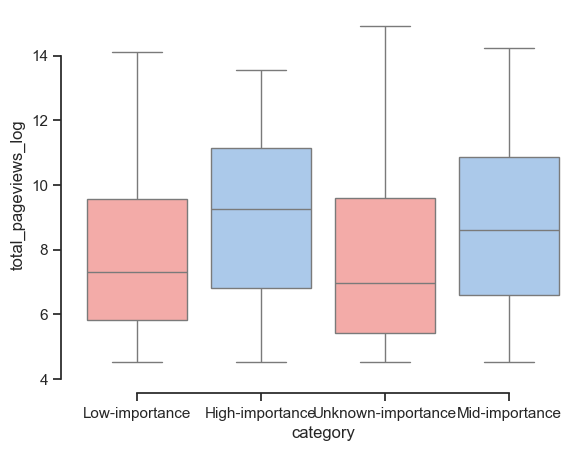

In [32]:
sns.boxplot(x="category", y="total_pageviews_log",
            hue="category", palette=["r", "b"],
            data=df)
sns.despine(offset=10, trim=True)